In [4]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pycm import ConfusionMatrix
from pycm.utils import axes_gen

from models.mstcn import MultiStageModel

ckpt_path = './logs/250428-150256_TeCNO_Cataract101_mstcn_MultiStageModel/checkpoints/epoch=24-val_loss=1.53.ckpt'

video_path = f'logs/250428-095621_FeatureExtraction_Cataract101FeatureExtract_cnn_OneHeadResNet50Model/cataract_pickle_export'

test_set = [(
        f"{video_path}/{1:.1f}fps/video_{i}_{1:.1f}fps.pkl"
    ) for i in range(86, 101)]

class HParams:
    def __init__(self, mstcn_stages=None, mstcn_layers=None, mstcn_f_maps=None, mstcn_f_dim=None, out_features=None, mstcn_causal_conv=None):
        self.mstcn_stages = mstcn_stages
        self.mstcn_layers = mstcn_layers
        self.mstcn_f_maps = mstcn_f_maps
        self.mstcn_f_dim = mstcn_f_dim
        self.out_features = out_features
        self.mstcn_causal_conv = mstcn_causal_conv

def load_video(path):
    unpickled_x = pd.read_pickle(path)
    stem = np.asarray(unpickled_x[0],
                      dtype=np.float32)[::1]
    y_hat = np.asarray(unpickled_x[1],
                       dtype=np.float32)[::1]
    y = np.asarray(unpickled_x[2])[::1]
    return stem, y_hat, y


def get_phase_acc(true_label, pred):
    pred = torch.FloatTensor(pred)
    pred_phase = torch.softmax(pred, dim=0)
    labels_pred = torch.argmax(pred_phase, dim=0).cpu().numpy()
    cm_ret = ConfusionMatrix(
        actual_vector=true_label,
        predict_vector=labels_pred,
    )

    # Plot confusion matrix
    cm_rounded = cm_ret.to_array(normalized=True)
    cm_rounded = np.round(cm_rounded, decimals=2)
    plot_title = "Confusion Matrix (Noramlized)"
    fig, ax = plt.subplots()
    fig.canvas.manager.set_window_title(plot_title)
    plt.imshow(cm_rounded, cmap=plt.cm.Reds)
    plt.colorbar()
    axes_gen(ax, cm_ret.classes, cm_rounded, plot_title, plt.cm.Reds, True, 'matplotlib')

    return cm_ret.Overall_ACC, cm_ret.PPV, cm_ret.TPR, cm_ret.classes, cm_ret.F1_Macro


def plot_boxplot(input_list, metric):
    keys = sorted(set().union(*(d.keys() for d in input_list)))
    box_data = []
    for key in keys:
        values = [d[key] for d in input_list if key in d and d[key] != 'None']
        box_data.append(values)
    keys = [key + 1 for key in keys]
    all_vals = [x for sublist in box_data for x in sublist]
    print(f'Average Stage-wise {metric}: {np.mean(all_vals)} +- {np.std(all_vals)}')
    plt.figure(figsize=(10, 6))
    plt.boxplot(box_data, tick_labels=keys, patch_artist=True)
    plt.xlabel('Class')
    plt.ylabel('Values')
    plt.title(f'{metric} for Each Surgical Stage')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def main():
    acc_list = []
    ppv_list = []
    tpr_list = []
    f1_list = []

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = MultiStageModel(HParams(
        mstcn_stages=2,
        mstcn_layers=9,
        mstcn_f_maps=64,
        mstcn_f_dim=2048,
        out_features=10,
        mstcn_causal_conv=True
    ))
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=True)
    new_state_dict = {}
    for key, values in checkpoint['state_dict'].items():
        if key.startswith('model.'):
            new_key = key.replace('model.', '')
        else:
            new_key = key
        new_state_dict[new_key] = values
    for unwanted_key in ["ce_loss.weight"]:
        if unwanted_key in new_state_dict:
            del new_state_dict[unwanted_key]
    model.load_state_dict(new_state_dict, strict=True)
    model.to(device)
    model.eval()
    for test_entry in test_set:
        stem, _, y = load_video(test_entry)
        stem = torch.tensor(stem).unsqueeze(0).to(device)
        with torch.no_grad():
            stem = stem.transpose(2, 1)
            out_stem = model(stem)
        y_hat = out_stem[1].squeeze().cpu().numpy()
        acc, ppv, tpr, classes, f1 = get_phase_acc(y, y_hat)
        acc_list.append(acc)
        ppv_list.append(ppv)
        tpr_list.append(tpr)
        f1_list.append(f1)
    print(f"Average Accuracy: {np.mean(acc_list)} +- {np.std(acc_list)}")
    print(f"Average F1: {np.mean(f1_list)} +- {np.std(f1_list)}")
    plot_boxplot(ppv_list, 'Precision')
    plot_boxplot(tpr_list, 'Recall')


Using device: mps
num_stages_classification: 2, num_layers: 9, num_f_maps: 64, dim: 2048
Average Accuracy: 0.8804088548660248 +- 0.06601082400428494
Average F1: 0.8481890055216252 +- 0.06828784965380977
Average Stage-wise Precision: 0.8823028342088354 +- 0.17049804781568514


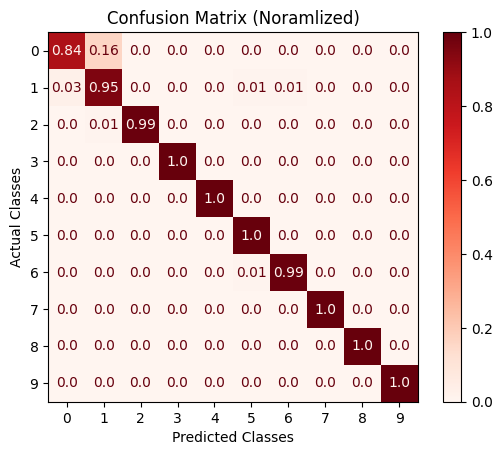

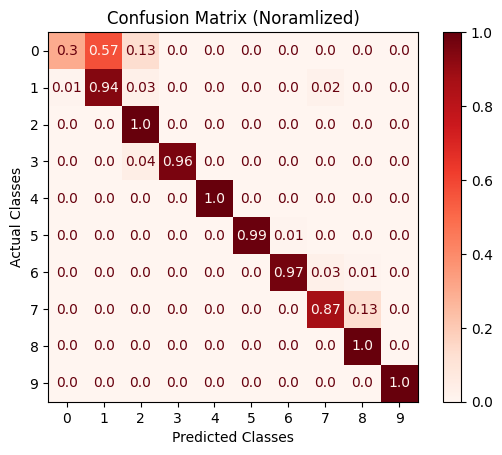

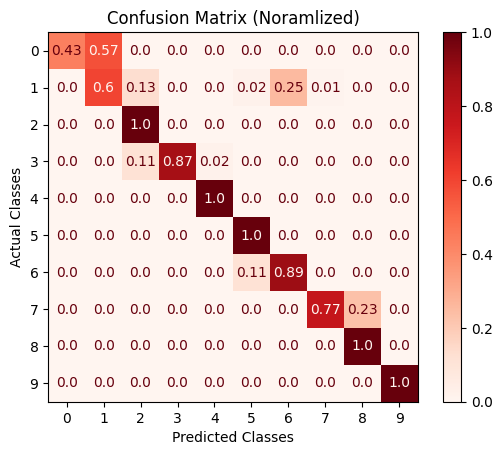

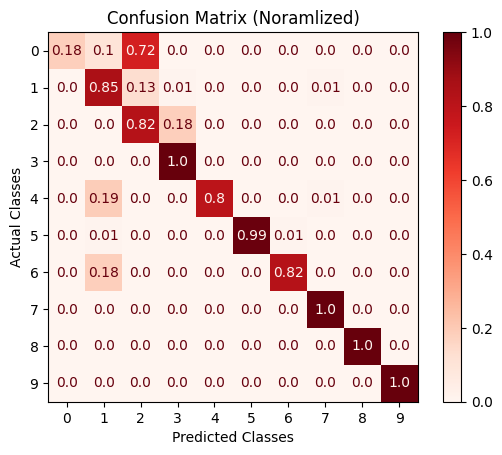

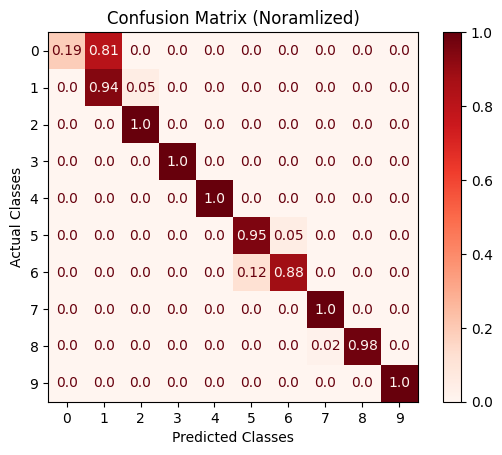

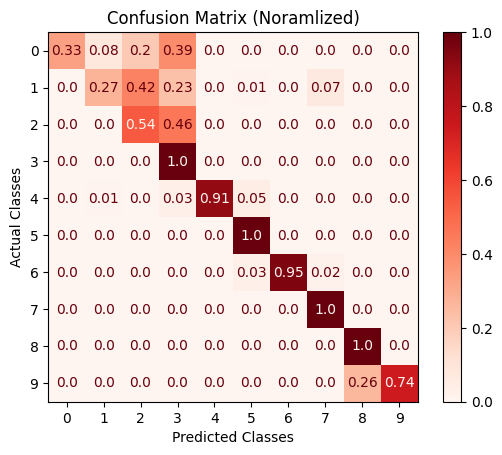

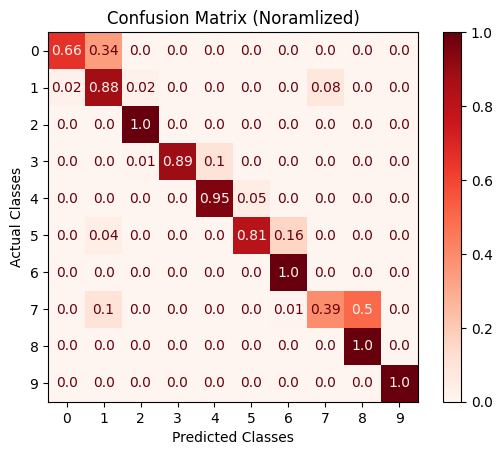

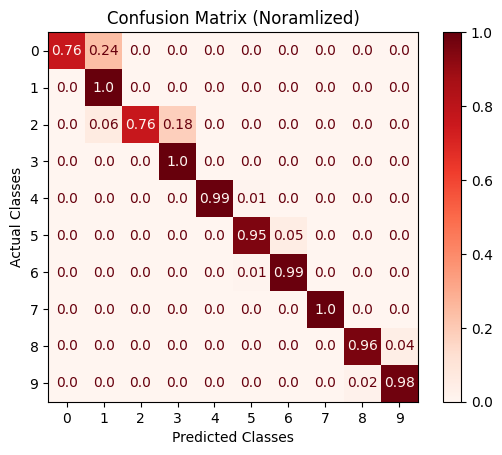

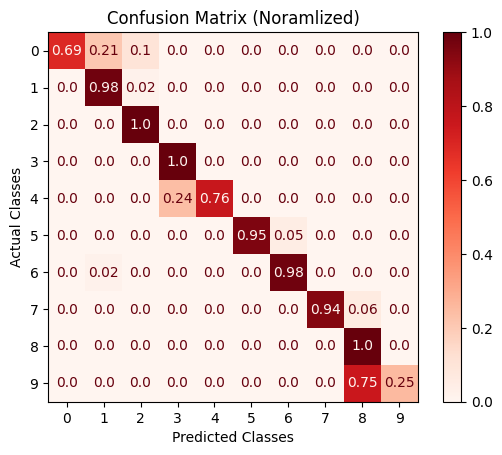

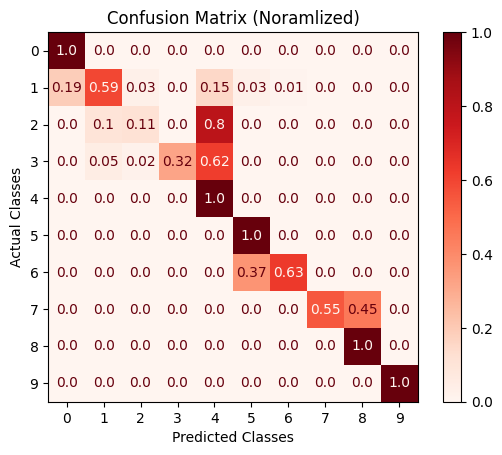

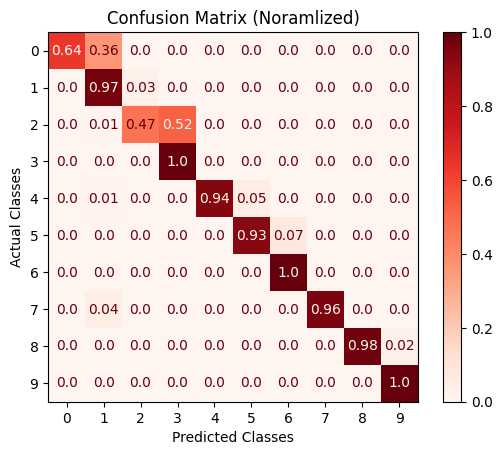

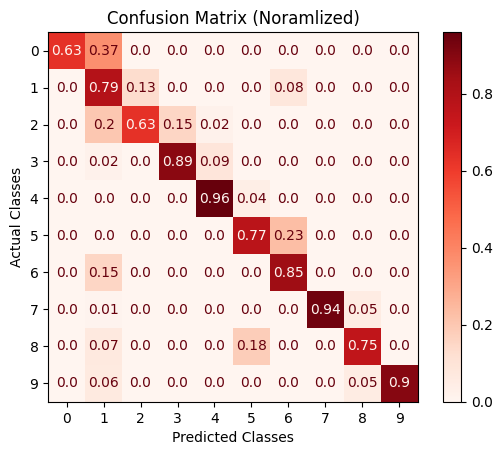

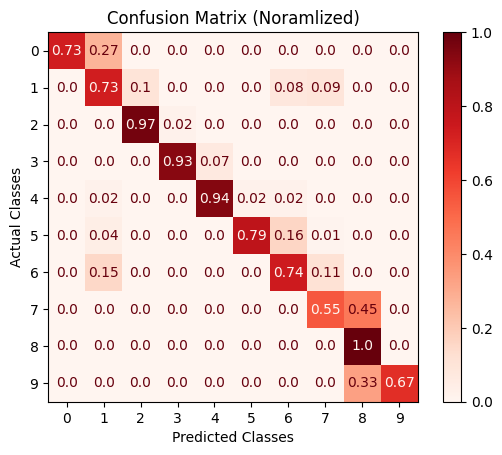

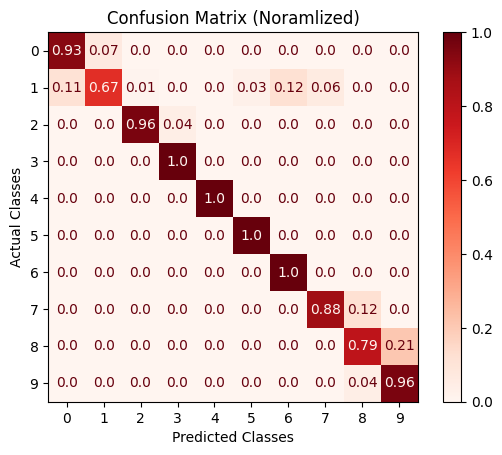

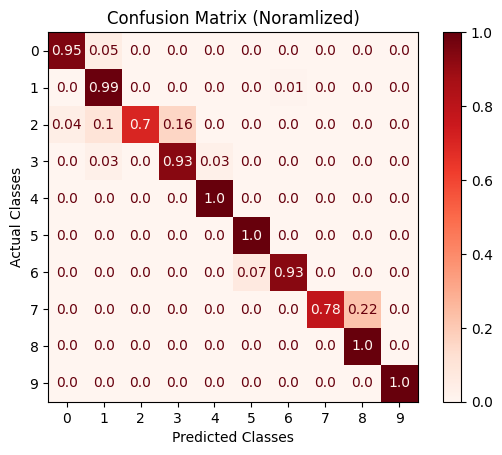

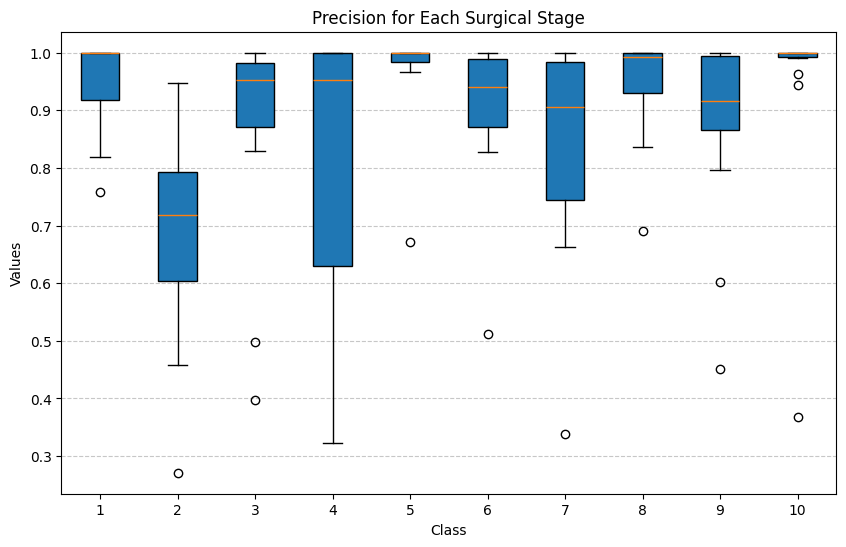

Average Stage-wise Recall: 0.8650191853209189 +- 0.20171717072473083


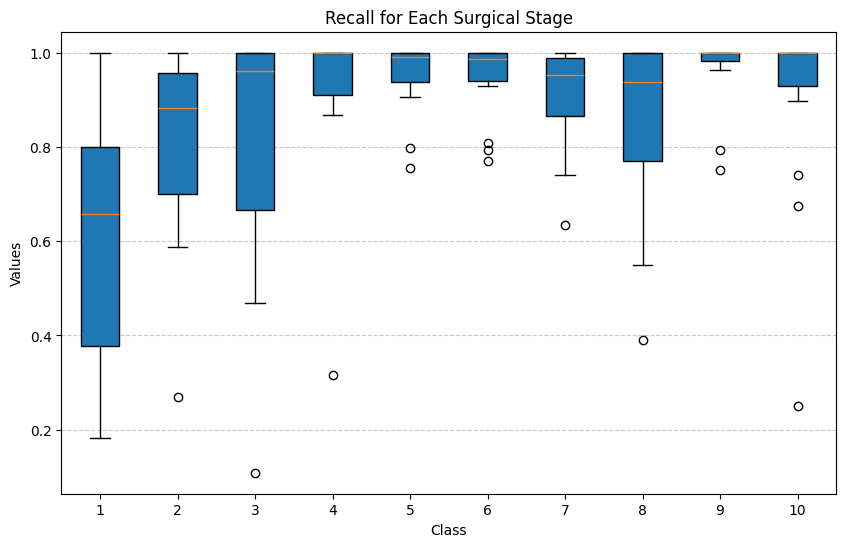

In [5]:
main()

Using device: mps
num_stages_classification: 2, num_layers: 9, num_f_maps: 64, dim: 2048


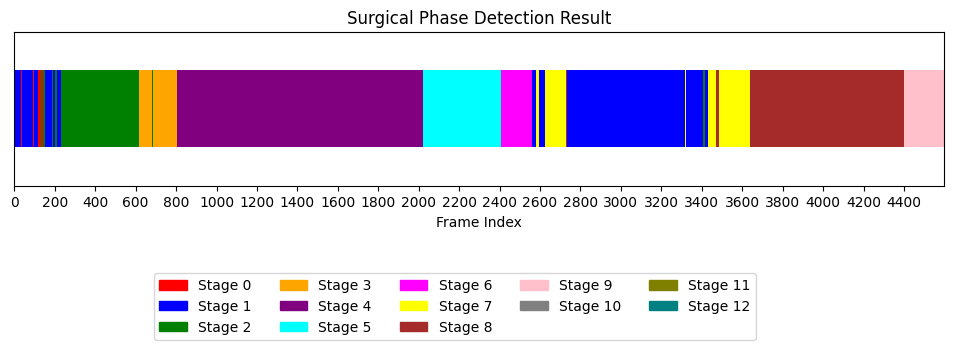

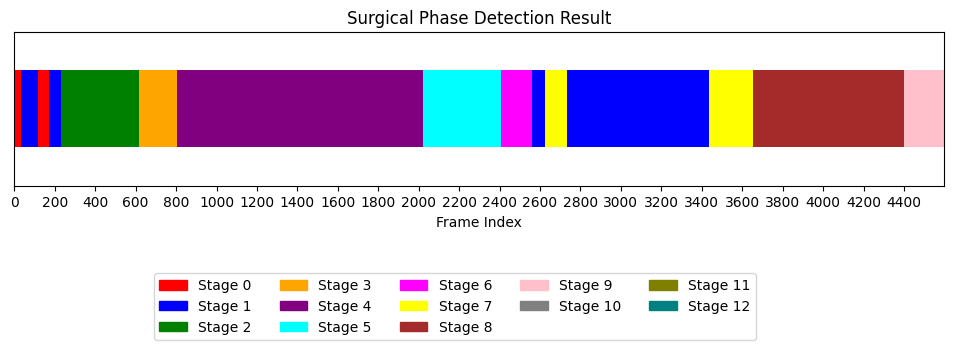

In [6]:
def inference(video_idx):
    test_video = f"{video_path}/{1:.1f}fps/video_{video_idx}_{1:.1f}fps.pkl"
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = MultiStageModel(HParams(
        mstcn_stages=2,
        mstcn_layers=9,
        mstcn_f_maps=64,
        mstcn_f_dim=2048,
        out_features=10,
        mstcn_causal_conv=True
    ))
    checkpoint = torch.load(ckpt_path, map_location=device, weights_only=True)
    new_state_dict = {}
    for key, values in checkpoint['state_dict'].items():
        if key.startswith('model.'):
            new_key = key.replace('model.', '')
        else:
            new_key = key
        new_state_dict[new_key] = values
    for unwanted_key in ["ce_loss.weight"]:
        if unwanted_key in new_state_dict:
            del new_state_dict[unwanted_key]
    model.load_state_dict(new_state_dict, strict=True)
    model.to(device)
    model.eval()

    stem, _, y = load_video(test_video)
    stem = torch.tensor(stem).unsqueeze(0).to(device)
    with torch.no_grad():
        stem = stem.transpose(2, 1)
        out_stem = model(stem)
    pred = out_stem[1].squeeze().cpu().numpy()
    pred = torch.FloatTensor(pred)
    pred_phase = torch.softmax(pred, dim=0)
    labels_pred = torch.argmax(pred_phase, dim=0).cpu().numpy().tolist()
    return labels_pred, y

def group_labels(labels):
    if len(labels) == 0:
        return []
    groups = []
    current_label = labels[0]
    start_index = 0
    for i, label in enumerate(labels):
        if label != current_label:
            groups.append((start_index, i - 1, current_label))
            start_index = i
            current_label = label
    groups.append((start_index, len(labels) - 1, current_label))
    return groups


def plot_surgical_phases(labels):
    groups = group_labels(labels)
    num_frames = len(labels)

    # Fixed mapping from surgical phase class to color.
    fixed_color_mapping = {
        0: 'red',
        1: 'blue',
        2: 'green',
        3: 'orange',
        4: 'purple',
        5: 'cyan',
        6: 'magenta',
        7: 'yellow',
        8: 'brown',
        9: 'pink',
        10: 'gray',
        11: 'olive',
        12: 'teal'
    }

    fig, ax = plt.subplots(figsize=(12, 2))

    bar_y = 0.25
    bar_height = 0.5
    ax.add_patch(patches.Rectangle((0, bar_y), num_frames, bar_height,
                                   facecolor='lightgray', edgecolor='none'))

    for start, end, lbl in groups:
        width = end - start + 1
        color = fixed_color_mapping.get(lbl, 'black')  # default to black if not mapped
        ax.add_patch(patches.Rectangle((start, bar_y), width, bar_height,
                                       facecolor=color, edgecolor='none'))

    ax.set_xlim(0, num_frames)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Frame Index')
    ax.set_title('Surgical Phase Detection Result')
    ax.set_xticks(np.arange(0, num_frames, 200))
    ax.set_yticks([])
    legend_handles = []
    for phase, color in fixed_color_mapping.items():
        legend_handles.append(patches.Patch(color=color, label=f'Stage {phase}'))
    ax.legend(
        handles=legend_handles,
        loc="lower left",
        bbox_to_anchor=(0.15, -1, num_frames, 0.5), 
        ncol=5,
        borderaxespad=0.
    )
    plt.show()


pred, gt = inference(87)
plot_surgical_phases(pred)
plot_surgical_phases(gt)